In [41]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# =========================
# 2. LOAD DATA FROM SQL SERVER
# =========================
server   = r"IBM-5SDQPM3\MSSQLSERVER01"
database = "D2C_SupplyChain"

connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

engine = create_engine(connection_string)

with engine.connect() as conn:
    query = text("SELECT * FROM Orders")   # adjust if you need specific columns
    df = pd.read_sql(query, conn)

print("Data loaded from SQL Server")
print(df.head())

Data loaded from SQL Server
   OrderLineID InvoiceNo StockCode                          Description  \
0            1    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1            2    536365     71053                  WHITE METAL LANTERN   
2            3    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3            4    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4            5    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

   Quantity InvoiceDate  UnitPrice CustomerID         Country  
0         6  2010-12-01       2.55      17850  United Kingdom  
1         6  2010-12-01       3.39      17850  United Kingdom  
2         8  2010-12-01       2.75      17850  United Kingdom  
3         6  2010-12-01       3.39      17850  United Kingdom  
4         6  2010-12-01       3.39      17850  United Kingdom  


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8444 entries, 0 to 8443
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderLineID  8444 non-null   int64         
 1   InvoiceNo    8444 non-null   object        
 2   StockCode    8444 non-null   object        
 3   Description  8442 non-null   object        
 4   Quantity     8444 non-null   int64         
 5   InvoiceDate  8444 non-null   datetime64[ns]
 6   UnitPrice    8444 non-null   float64       
 7   CustomerID   5772 non-null   object        
 8   Country      8444 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 593.8+ KB


In [43]:
df.shape

(8444, 9)

In [44]:
# =========================
# 3. DATA PREPARATION
# =========================
#  Check the Number of Days Each SKU Was Sold
sku_days = daily.groupby('StockCode')['date'].nunique()
print(sku_days)


StockCode
10002           1
10080           1
10120           1
10123C          1
10124A          1
               ..
gift_0001_10    1
gift_0001_20    2
gift_0001_30    1
gift_0001_40    1
gift_0001_50    1
Name: date, Length: 3755, dtype: int64


In [45]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]  # remove negative/returns
df['date'] = df['InvoiceDate'].dt.date

# Daily sales per SKU
daily = df.groupby(['date', 'StockCode'])['Quantity'].sum().reset_index()

# Identify SKUs sold on >10 distinct days
sku_days = daily.groupby('StockCode')['date'].nunique()
repeat_skus = sku_days[sku_days > 2].index

# Top 5 SKUs by total sales
filtered_sku_total = daily[daily['StockCode'].isin(repeat_skus)].groupby('StockCode')['Quantity'].sum()
top_skus = filtered_sku_total.sort_values(ascending=False).head(5).index.tolist()

print("Top 5 SKUs:", top_skus)

Top 5 SKUs: ['23343', '20713', '23131', '23084', '23231']


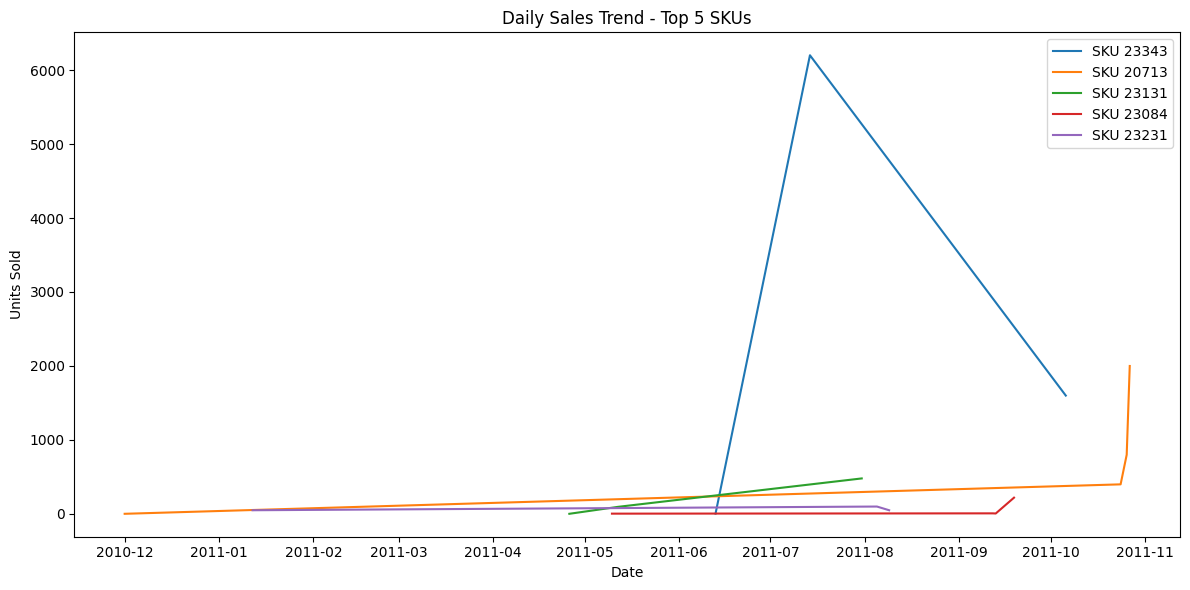

In [46]:
## A) Daily sales trends (line plot)
plt.figure(figsize=(12,6))
for sku in top_skus:
    sku_data = daily[daily['StockCode'] == sku]
    plt.plot(sku_data['date'], sku_data['Quantity'], label=f'SKU {sku}')
plt.title("Daily Sales Trend - Top 5 SKUs")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

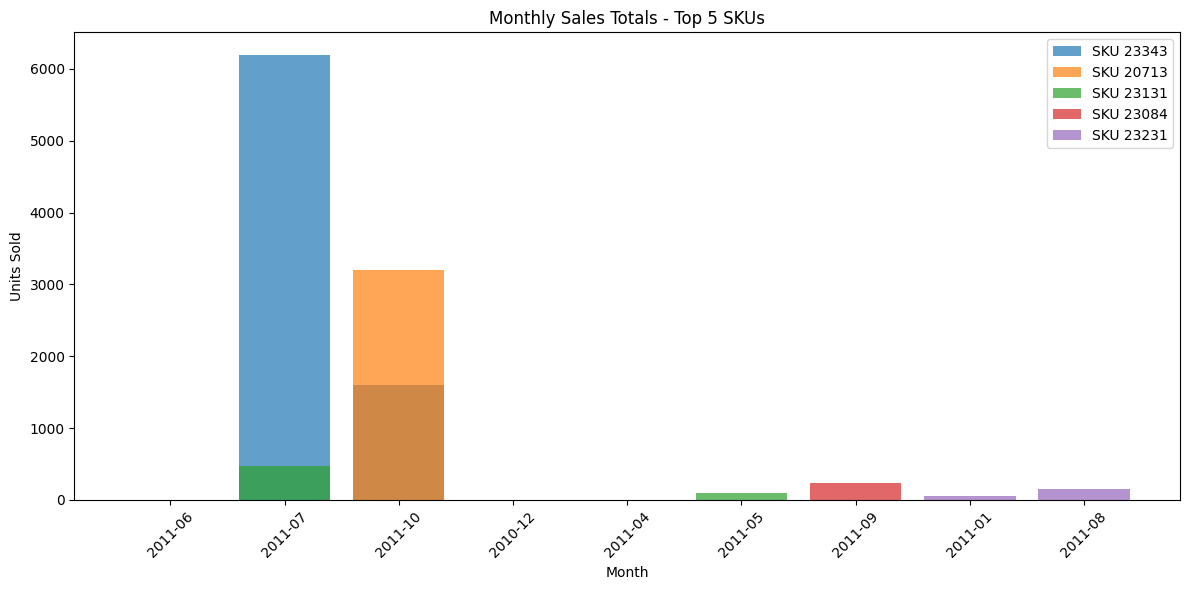

In [47]:
## B) Monthly totals (bar chart)
df['year_month'] = df['InvoiceDate'].dt.to_period('M')
monthly = df.groupby(['year_month','StockCode'])['Quantity'].sum().reset_index()

plt.figure(figsize=(12,6))
for sku in top_skus:
    sku_data = monthly[monthly['StockCode'] == sku]
    plt.bar(sku_data['year_month'].astype(str), sku_data['Quantity'], alpha=0.7, label=f'SKU {sku}')
plt.title("Monthly Sales Totals - Top 5 SKUs")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing


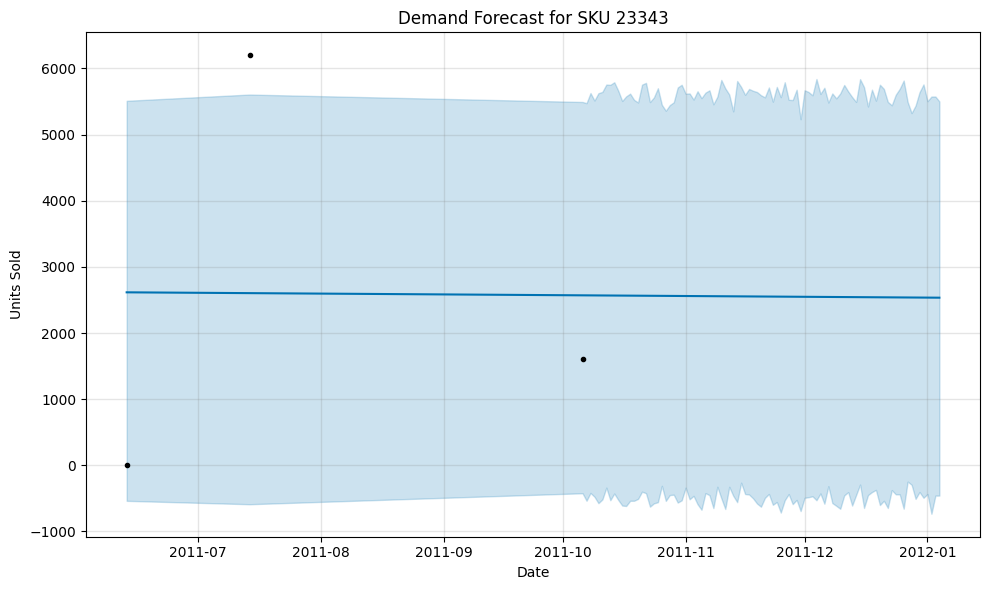

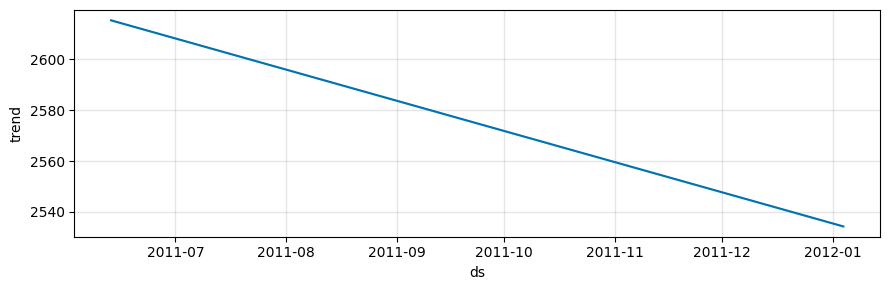

Forecast and components plotted for SKU 23343


In [50]:
# =========================
# 5. DEMAND FORECASTING (Prophet)
# =========================

# Choose a SKU for forecasting
sku_to_forecast = top_skus[0]  # Forecast top SKU (e.g., SKU 23343)
sku_data = daily[daily['StockCode'] == sku_to_forecast][['date', 'Quantity']]
sku_data = sku_data.rename(columns={'date': 'ds', 'Quantity': 'y'})  # Prophet requires 'ds' and 'y'

# Fit the Prophet model
model = Prophet()
model.fit(sku_data)

# Forecast the next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Forecast plot
fig1 = model.plot(forecast)
plt.title(f"Demand Forecast for SKU {sku_to_forecast}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.tight_layout()

# Save forecast plot
fig1.savefig('forecast_sku_23343.png')  # Save as image file
plt.show()

# Components plot (trend + seasonality)
fig2 = model.plot_components(forecast)
plt.tight_layout()

# Save components plot
fig2.savefig('forecast_components_sku_23343.png')  # Save as image file
plt.show()

print(f"Forecast and components plotted for SKU {sku_to_forecast}")

